<a href="https://colab.research.google.com/github/chi-hun/chi-hun/blob/main/image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import glob
import tqdm.auto
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/공부/archi.zip'

train_path = glob.glob('/content/cifar10/train/*/*.png')
test_path = glob.glob('/content/cifar10/test/*/*.png')

train_df = pd.DataFrame(train_path, columns=['path'])
test_df = pd.DataFrame(test_path, columns=['path'])
train_df['label'] = train_df['path'].str.split('/').str[-1].str.split('_').str[-1].str.split('.').str[0]
test_df['label'] = test_df['path'].str.split('/').str[-1].str.split('_').str[-1].str.split('.').str[0]

train_df, val_df = train_test_split(train_df, stratify=train_df['label'])

train_df = pd.get_dummies(train_df, columns=['label'])
val_df = pd.get_dummies(val_df, columns=['label'])
test_df = pd.get_dummies(test_df, columns=['label'])

classes = []
for i in train_df.columns[1:]:
    classes.append(i.split('_')[-1])

train_df.shape, val_df.shape, test_df.shape

In [13]:
CFG = {'img_size' : 224,
       'batch_size' : 32,
       'lr' : 1e-3,
       'device' : 'cuda',
       'epoch' : 10}

In [14]:
class make_dataset(torch.utils.data.Dataset):
    def __init__(self, path, label=None):
        self.path = path
        self.label = label

    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        img = cv2.imread(self.path[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (CFG['img_size'], CFG['img_size']))
        totensor = torchvision.transforms.ToTensor()
        img = totensor(img)

        if self.label is not None:
            label = torch.tensor(self.label[idx], dtype=torch.float)
            return img, label
        else:
            return img

In [15]:
train_ds = make_dataset(train_df['path'].values, train_df.iloc[:, 1:].values)
val_ds = make_dataset(val_df['path'].values, val_df.iloc[:, 1:].values)
test_ds = make_dataset(test_df['path'].values)

In [16]:
train_dr = torch.utils.data.DataLoader(train_ds, batch_size=CFG['batch_size'], shuffle=True)
val_dr = torch.utils.data.DataLoader(val_ds, batch_size=CFG['batch_size'], shuffle=True)
test_dr = torch.utils.data.DataLoader(test_ds, batch_size=CFG['batch_size'], shuffle=False)

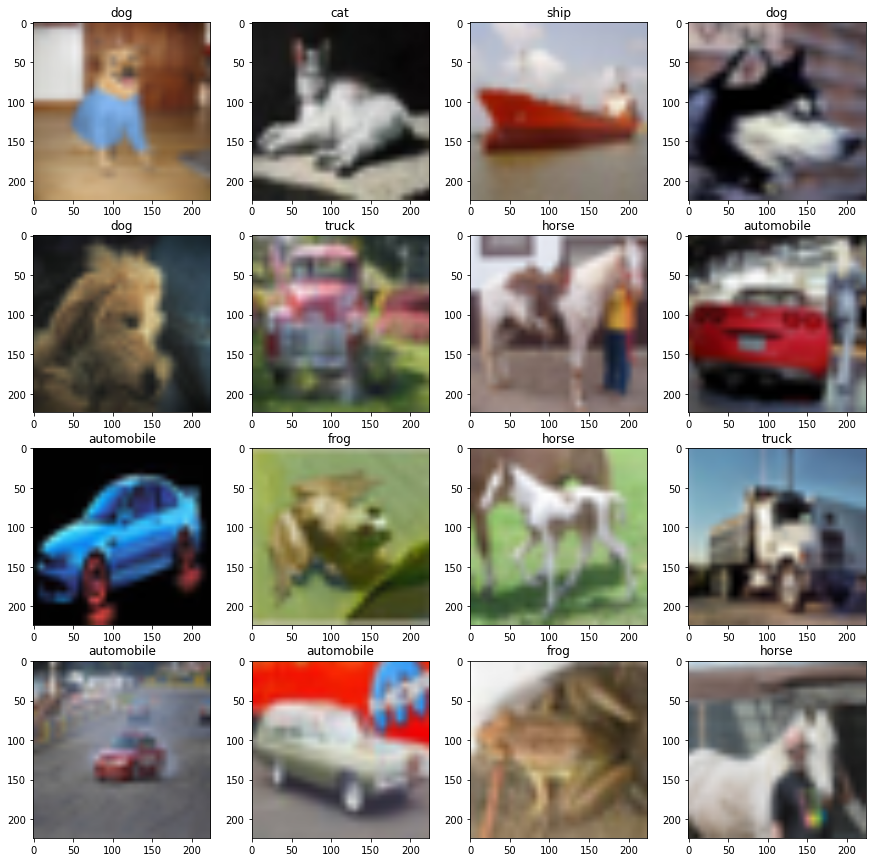

In [17]:
img, label = next(iter(train_dr))
plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(np.transpose(img[i],(1,2,0)))
    plt.title(classes[np.argmax(label[i], axis=0)])
plt.show()

In [24]:
class model_make(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layer = nn.Sequential(nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(16),
                                       nn.MaxPool2d(2),
                                       nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(32),
                                       nn.MaxPool2d(2),
                                       nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64),
                                       nn.MaxPool2d(2),
                                       nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128),
                                       nn.MaxPool2d(2)
                                       )
        self.linear = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                    nn.Flatten(),
                                    nn.Linear(128,64),
                                    nn.ReLU(),
                                    nn.Linear(64,10),
                                    # nn.Softmax()
                                    )
    
    def forward(self, x):
        x = self.cnn_layer(x)
        x = self.linear(x)
        return x

In [25]:
model = model_make()
model = model.to(CFG['device'])
summary(model, (3, CFG['img_size'], CFG['img_size']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
       BatchNorm2d-3         [-1, 16, 224, 224]              32
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,640
              ReLU-6         [-1, 32, 112, 112]               0
       BatchNorm2d-7         [-1, 32, 112, 112]              64
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,496
             ReLU-10           [-1, 64, 56, 56]               0
      BatchNorm2d-11           [-1, 64, 56, 56]             128
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
             ReLU-14          [-1, 128,

In [36]:
def train(train_dr, val_dr, model, optimizer, loss_fn):
    losses = 0
    accs = 0
    model = model.to(CFG['device'])
    model.train()
    for i, (train_x, train_y) in enumerate(tqdm.auto.tqdm(train_dr)):
        train_x = train_x.to(CFG['device'])
        train_y = train_y.to(CFG['device'])
        
        pre = model(train_x)
        loss = loss_fn(pre, train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (torch.argmax(train_y, dim=1) == torch.argmax(pre, dim=1)).sum() / CFG['batch_size']
        
        losses += loss.item()
        accs += acc.item()

        print(f'\r loss : {round(losses/(i+1), 2)}, acc : {round(accs/(i+1), 2)}', end="")

    model.eval()
    with torch.no_grad():
        val_losses = 0
        val_accs = 0
        for i, (val_x, val_y) in enumerate(val_dr):
            val_x = val_x.to(CFG['device'])
            val_y = val_y.to(CFG['device'])
            pre = model(val_x)
            loss = loss_fn(pre, val_y)
            acc = (torch.argmax(val_y, dim=1) == torch.argmax(pre, dim=1)).sum() / CFG['batch_size']
            val_losses += loss.item()
            val_accs += acc.item()
        print(f', val_loss : {round(val_losses/len(val_dr), 2)}, val_acc : {round(val_accs/len(val_dr), 2)}')
    #print(f'loss : {round(losses/len(train_dr), 2)}, acc : {round(accs/len(train_dr.dataset), 2)}, val_loss : {round(val_losses/len(val_dr), 2)}, val_acc : {round(val_accs/len(val_dr.dataset), 2)}')

    return losses/len(train_dr),  val_losses/len(val_dr), accs/len(train_dr), val_accs/len(val_dr)


In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'])
loss_fn = nn.CrossEntropyLoss()

In [28]:
his = {'train_loss' : [], 'val_loss' : [], 'train_acc' : [], 'val_acc' : []}
for i in range(CFG['epoch']):
    epochs = CFG['epoch']
    print(f'{i+1} / {epochs}')
    train_loss, val_loss, train_acc, val_acc = train(train_dr, val_dr, model, optimizer, loss_fn)
    his['train_loss'].append(train_loss)
    his['val_loss'].append(val_loss)
    his['train_acc'].append(train_acc)
    his['val_acc'].append(val_acc)

1 / 10


  0%|          | 0/1172 [00:00<?, ?it/s]

 loss : 1.61, acc : 0.41val_loss : 1.39, val_acc : 0.49
2 / 10


  0%|          | 0/1172 [00:00<?, ?it/s]

 loss : 1.22, acc : 0.56val_loss : 1.11, val_acc : 0.6
3 / 10


  0%|          | 0/1172 [00:00<?, ?it/s]

 loss : 1.05, acc : 0.63val_loss : 1.01, val_acc : 0.64
4 / 10


  0%|          | 0/1172 [00:00<?, ?it/s]

 loss : 0.95, acc : 0.66val_loss : 0.99, val_acc : 0.65
5 / 10


  0%|          | 0/1172 [00:00<?, ?it/s]

 loss : 0.88, acc : 0.69val_loss : 0.98, val_acc : 0.66
6 / 10


  0%|          | 0/1172 [00:00<?, ?it/s]

 loss : 0.82, acc : 0.71val_loss : 0.92, val_acc : 0.68
7 / 10


  0%|          | 0/1172 [00:00<?, ?it/s]

 loss : 0.78, acc : 0.72val_loss : 0.98, val_acc : 0.66
8 / 10


  0%|          | 0/1172 [00:00<?, ?it/s]

 loss : 0.74, acc : 0.74val_loss : 0.84, val_acc : 0.71
9 / 10


  0%|          | 0/1172 [00:00<?, ?it/s]

 loss : 0.7, acc : 0.75val_loss : 0.91, val_acc : 0.69
10 / 10


  0%|          | 0/1172 [00:00<?, ?it/s]

 loss : 0.67, acc : 0.76val_loss : 0.84, val_acc : 0.71


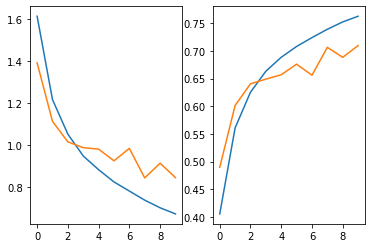

In [29]:
plt.subplot(1,2,1)
plt.plot(his['train_loss'])
plt.plot(his['val_loss'])
plt.subplot(1,2,2)
plt.plot(his['train_acc'])
plt.plot(his['val_acc'])

In [ ]:
resnet = torchvision.models.resnet50(pretrained=True).to(CFG['device'])
for param in resnet.parameters():
    param.requies_grad = False

in_features = resnet.fc.in_features

classifier = torch.nn.Sequential(torch.nn.Linear(in_features,1024),
                                 torch.nn.ReLU(),
                                 torch.nn.Dropout(0.5),
                                 torch.nn.Linear(1024,10))
resnet.fc = classifier

losscol = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=resnet.parameters(), lr=2e-2)
resnet.to(CFG['device'])

In [37]:
his = {'train_loss' : [], 'val_loss' : [], 'train_acc' : [], 'val_acc' : []}
for i in range(CFG['epoch']):
    epochs = CFG['epoch']
    print(f'{i+1} / {epochs}')
    train_loss, val_loss, train_acc, val_acc = train(train_dr, val_dr, resnet, optimizer, loss_fn)
    his['train_loss'].append(train_loss)
    his['val_loss'].append(val_loss)
    his['train_acc'].append(train_acc)
    his['val_acc'].append(val_acc)

1 / 10


  0%|          | 0/1172 [00:00<?, ?it/s]

 loss : 0.41, acc : 0.87, val_loss : 0.19, val_acc : 0.94
2 / 10


  0%|          | 0/1172 [00:00<?, ?it/s]

 loss : 0.15, acc : 0.95, val_loss : 0.14, val_acc : 0.95
3 / 10


  0%|          | 0/1172 [00:00<?, ?it/s]

 loss : 0.08, acc : 0.97, val_loss : 0.18, val_acc : 0.94
4 / 10


  0%|          | 0/1172 [00:00<?, ?it/s]

 loss : 0.06, acc : 0.98, val_loss : 0.15, val_acc : 0.95
5 / 10


  0%|          | 0/1172 [00:00<?, ?it/s]

 loss : 0.03, acc : 0.99

KeyboardInterrupt: ignored